In [1]:
import os
if not os.path.exists("train.csv"):
  !wget --header="Host: datahack-prod.s3.amazonaws.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/84.0.4147.89 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Referer: https://datahack.analyticsvidhya.com/contest/janatahack-machine-learning-in-agriculture/" "https://datahack-prod.s3.amazonaws.com/train_file/train_yaOffsB.csv" -c -O 'train.csv'

if not os.path.exists("test.csv"):
  !wget --header="Host: datahack-prod.s3.amazonaws.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/84.0.4147.89 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Referer: https://datahack.analyticsvidhya.com/contest/janatahack-machine-learning-in-agriculture/" "https://datahack-prod.s3.amazonaws.com/test_file/test_pFkWwen.csv" -c -O 'test.csv'

--2020-07-26 15:08:13--  https://datahack-prod.s3.amazonaws.com/train_file/train_yaOffsB.csv
Resolving datahack-prod.s3.amazonaws.com (datahack-prod.s3.amazonaws.com)... 52.219.64.124
Connecting to datahack-prod.s3.amazonaws.com (datahack-prod.s3.amazonaws.com)|52.219.64.124|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2997136 (2.9M) [text/csv]
Saving to: ‘train.csv’

train.csv           100%[===================>]   2.86M  3.81MB/s    in 0.8s    

2020-07-26 15:08:14 (3.81 MB/s) - ‘train.csv’ saved [2997136/2997136]

--2020-07-26 15:08:16--  https://datahack-prod.s3.amazonaws.com/test_file/test_pFkWwen.csv
Resolving datahack-prod.s3.amazonaws.com (datahack-prod.s3.amazonaws.com)... 52.219.66.116
Connecting to datahack-prod.s3.amazonaws.com (datahack-prod.s3.amazonaws.com)|52.219.66.116|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1881912 (1.8M) [text/csv]
Saving to: ‘test.csv’

test.csv            100%[===================>]   1.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import os

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [121]:
# ID	: UniqueID
# Estimated_Insects_Count	: Estimated insects count per square meter
# Crop_Type :	Category of Crop(0,1)
# Soil_Type	: Category of Soil (0,1)
# Pesticide_Use_Category : Type of pesticides uses (1- Never, 2-Previously Used, 3-Currently Using)
# Number_Doses_Week :	Number of doses per week
# Number_Weeks_Used	: Number of weeks used
# Number_Weeks_Quit	: Number of weeks quit
# Season :	Season Category (1,2,3)
# Crop_Damage	: Crop Damage Category (0=alive, 1=Damage due to other causes, 2=Damage due to Pesticides)

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
merge = pd.concat([train,test]).reset_index(drop=True)
print(merge.shape)

# test['Estimated_Insects_Count_per_km_sq'] = test['Estimated_Insects_Count'].apply(lambda x:x*0.000001) 
# train['Estimated_Insects_Count_per_km_sq'] = train['Estimated_Insects_Count'].apply(lambda x:x*0.000001) 

from sklearn.linear_model import LinearRegression,LogisticRegression
from lightgbm import LGBMRegressor,LGBMClassifier
from xgboost import XGBRegressor,XGBClassifier
from sklearn.model_selection import train_test_split

imputer = LGBMRegressor()
use_train = merge[~merge.Number_Weeks_Used.isna()]
X = use_train.drop(['ID','Number_Weeks_Used','Crop_Damage'],axis=1)
Y = use_train[['Number_Weeks_Used']]
impute_train_x,impute_test_x,impute_train_y,impute_test_y = train_test_split(X,Y,test_size=0.2,shuffle=True)
imputer.fit(impute_train_x,impute_train_y)
print(imputer.score(impute_test_x,impute_test_y))

imputer.fit(X,Y)

na_train = merge[merge.Number_Weeks_Used.isna()]
output = imputer.predict(na_train.drop(['ID','Number_Weeks_Used','Crop_Damage'],axis=1))
na_train['Number_Weeks_Used'] = output
# print(na_train.shape,use_train.shape)

merge = pd.concat([use_train,na_train]).reset_index(drop=True)
# # print(merge.shape)
merge.Number_Weeks_Used = merge.Number_Weeks_Used.fillna(merge.Number_Weeks_Used.dropna().values.mean())
merge['Number_Weeks_Used'] = merge['Number_Weeks_Used'].apply(lambda x:int(x))
merge['Number_Weeks_Quit'] = merge['Number_Weeks_Quit'].apply(lambda x:int(x))
merge['total_doses_taken'] = merge.apply(lambda x:x['Number_Doses_Week']*x['Number_Weeks_Used'],axis=1)
merge['num_farming_weeks'] = merge.apply(lambda x:x['Number_Weeks_Used']+x['Number_Weeks_Quit'],axis=1)

cat_columns = ['Crop_Type',"Soil_Type","Pesticide_Use_Category","Season"]

m = merge.groupby(cat_columns)['Number_Doses_Week',"Number_Weeks_Used","Number_Weeks_Quit","total_doses_taken","num_farming_weeks"]
m = m.agg(['mean',"max"]).reset_index()
columns = []
for i in m.columns:
  if len(i) >1 and i[1] != "":
    columns.append("_".join(i))
  else:
    columns.append(i[0])
m.columns = columns
merge = merge.merge(m,on=cat_columns,how="left")

non_cat_columns = merge.drop(cat_columns+['Crop_Damage',"ID"],axis=1).columns

num_cols= ['Estimated_Insects_Count','Number_Doses_Week','Number_Weeks_Used','Number_Weeks_Quit','total_doses_taken','num_farming_weeks']

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
merge.loc[:,non_cat_columns] = scaler.fit_transform(merge[non_cat_columns])

train = merge[~merge.Crop_Damage.isna()]
test = merge[merge.Crop_Damage.isna()]
test.drop(['Crop_Damage'],axis=1,inplace=True)

train

(148168, 10)
0.717741978091306


,ID,Estimated_Insects_Count,Crop_Type,Soil_Type,Pesticide_Use_Category,Number_Doses_Week,Number_Weeks_Used,Number_Weeks_Quit,Season,Crop_Damage,total_doses_taken,num_farming_weeks,Number_Doses_Week_mean,Number_Doses_Week_max,Number_Weeks_Used_mean,Number_Weeks_Used_max,Number_Weeks_Quit_mean,Number_Weeks_Quit_max,total_doses_taken_mean,total_doses_taken_max,num_farming_weeks_mean,num_farming_weeks_max
0,F00000001,-1.425130,1,0,1,-1.665065,-2.337877,-0.967905,1,0.0,-1.308577,-3.252582,-6.620221,-9.526047,-5.637158,-9.580410,-1.573169,-1.591208,-5.089724,-6.793813,-7.484355,-9.443592
1,F00000003,-1.400400,1,0,1,-1.665065,-2.337877,-0.967905,2,1.0,-1.308577,-3.252582,-6.620221,-9.526047,-5.635542,-9.733816,-1.573169,-1.591208,-5.089724,-6.793813,-7.482747,-9.583175
2,F00000004,-1.343876,1,0,1,-1.665065,-2.337877,-0.967905,2,1.0,-1.308577,-3.252582,-6.620221,-9.526047,-5.635542,-9.733816,-1.573169,-1.591208,-5.089724,-6.793813,-7.482747,-9.583175
3,F00000005,-1.343876,1,1,1,-1.665065,-2.337877,-0.967905,2,1.0,-1.308577,-3.252582,-6.620221,-9.526047,-5.636532,-9.733816,-1.573169,-1.591208,-5.089724,-6.793813,-7.483733,-9.583175
4,F00000006,-1.243781,1,0,1,-1.665065,-2.337877,-0.967905,2,1.0,-1.308577,-3.252582,-6.620221,-9.526047,-5.635542,-9.733816,-1.573169,-1.591208,-5.089724,-6.793813,-7.482747,-9.583175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142270,F00155793,0.455476,1,0,2,2.199581,0.115813,0.651118,2,0.0,1.776657,0.669341,-1.393848,-0.264239,-0.713545,0.237586,0.265576,0.649795,-1.522449,-0.766643,-0.393149,0.187674
142271,F00155801,0.588543,1,0,2,-0.698903,0.770130,-0.664338,1,0.0,-0.331586,0.243045,-1.443144,-0.264239,-0.735186,-0.682852,0.280860,0.604975,-1.569961,-1.407831,-0.396450,-0.370660
142272,F00155882,1.346909,1,0,2,-1.020957,-0.293136,1.157062,2,0.0,-0.880072,0.669341,-1.393848,-0.264239,-0.713545,0.237586,0.265576,0.649795,-1.522449,-0.766643,-0.393149,0.187674
142273,F00155899,1.517659,1,0,2,-1.020957,-0.211346,1.157062,2,0.0,-0.862932,0.754600,-1.393848,-0.264239,-0.713545,0.237586,0.265576,0.649795,-1.522449,-0.766643,-0.393149,0.187674


In [122]:
# m = merge.groupby(['Crop_Type',"Soil_Type","Pesticide_Use_Category","Season"])['Number_Doses_Week',"Number_Weeks_Used","Number_Weeks_Quit","total_doses_taken","num_farming_weeks"]
# m = m.agg(['mean',"max","min"]).reset_index()
# columns = []
# for i in m.columns:
#   if len(i) >1 and i[1] != "":
#     columns.append("_".join(i))
#   else:
#     columns.append(i[0])
# m.columns = columns
# m

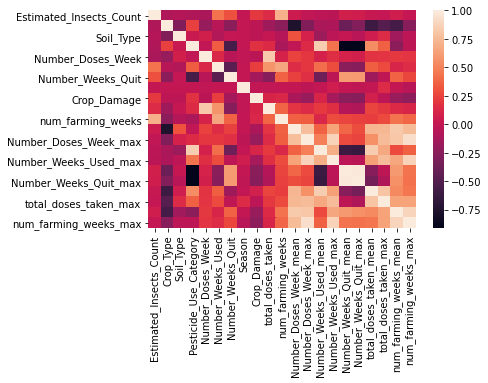

In [123]:
sns.heatmap(train.corr())

In [124]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88858 entries, 0 to 142274
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       88858 non-null  object 
 1   Estimated_Insects_Count  88858 non-null  float64
 2   Crop_Type                88858 non-null  int64  
 3   Soil_Type                88858 non-null  int64  
 4   Pesticide_Use_Category   88858 non-null  int64  
 5   Number_Doses_Week        88858 non-null  float64
 6   Number_Weeks_Used        88858 non-null  float64
 7   Number_Weeks_Quit        88858 non-null  float64
 8   Season                   88858 non-null  int64  
 9   Crop_Damage              88858 non-null  float64
 10  total_doses_taken        88858 non-null  float64
 11  num_farming_weeks        88858 non-null  float64
 12  Number_Doses_Week_mean   88858 non-null  float64
 13  Number_Doses_Week_max    88858 non-null  float64
 14  Number_Weeks_Used_mea

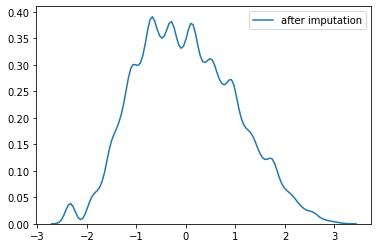

In [125]:
# sns.distplot(train.Estimated_Insects_Count)
# sns.kdeplot(na_train.Number_Weeks_Used,label="imputed")
# sns.kdeplot(use_train.Number_Weeks_Used,label="before imputation")
sns.kdeplot(merge.Number_Weeks_Used,label="after imputation")

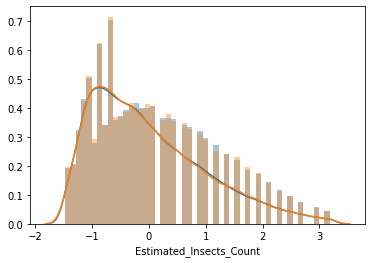

In [126]:
sns.distplot(train.Estimated_Insects_Count,label="train",)
sns.distplot(test.Estimated_Insects_Count,label="test")

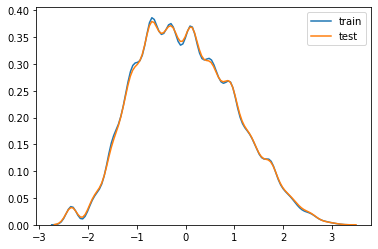

In [127]:
sns.kdeplot(train.Number_Weeks_Used,label="train")
sns.kdeplot(test.Number_Weeks_Used,label="test")

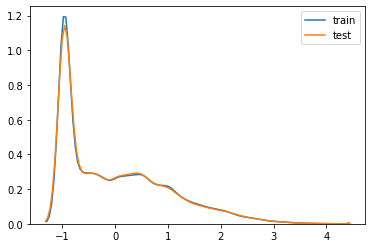

In [128]:
sns.kdeplot(train.Number_Weeks_Quit,label="train")
sns.kdeplot(test.Number_Weeks_Quit,label="test")

In [129]:
# sns.jointplot(x="Number_Weeks_Used",y="Crop_Type",data=train,kind="kde")
# sns.distplot(train["num_farming_weeks"])

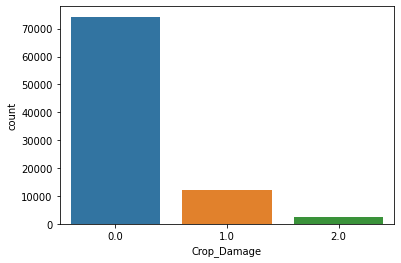

In [130]:
sns.countplot(train.Crop_Damage)

In [131]:
!pip install catboost

In [132]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split , KFold
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB,GaussianNB ,CategoricalNB
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier , AdaBoostClassifier

In [133]:
from sklearn.utils import class_weight
y = train[['Crop_Damage']].values.reshape((-1))
class_weights = class_weight.compute_class_weight('balanced',np.unique(y),y)
class_weights

array([ 0.39897806,  2.40670621, 12.80559158])

In [134]:
import warnings 
warnings.filterwarnings("ignore")

# X = train.drop(['ID','Crop_Damage'],axis=1)
# Y = train[['Crop_Damage']]

X = train.drop(['ID',"Crop_Damage"],axis=1)
Y = train[['Crop_Damage']]

# params={
#     "od_type":"Iter",
#     "od_wait":50,
#     "learning_rate":0.15,
#     "eval_metric":"Accuracy",
#     "verbose":50,
#     "boosting_type":"Plain",
#     # "class_weights":class_weights
# }

# from sklearn.utils import class_weight
# from sklearn.model_selection import KFold, StratifiedKFold

# y = train[['Crop_Damage']].values.reshape((-1))
# class_weights = class_weight.compute_class_weight('balanced',np.unique(y),y)
# class_weights

# n_folds=[4]
# for n_fold in n_folds:
#   print("\nPerforming on N_folds :",n_fold)
#   folds = StratifiedKFold(n_splits=n_fold,shuffle=True)
#   scores=[]
#   max_score = 0

#   for (train_idx,test_idx),i in list(zip(folds.split(X,Y),range(n_fold))):
#     test_set = (X.iloc[test_idx],Y.iloc[test_idx])
#     model = CatBoostClassifier(**params)
#     model.fit(X.iloc[train_idx],Y.iloc[train_idx],
#               cat_features=["Crop_Type",'Soil_Type','Pesticide_Use_Category','Season'],
#               eval_set=test_set)
    
#     # model= XGBClassifier(verbose=False)
#     # model.fit(X.iloc[train_idx],Y.iloc[train_idx],eval_set=[test_set],
#     #           early_stopping_rounds=25,verbose=False)
#     score = model.score(*test_set)
#     scores.append(score)
#     if score > max_score:
#       max_score=score
#       best_idx=train_idx
#       val_idx = test_idx
#     print("Model Score at fold %d : " % i,score)

#   print("mean_score",np.array(scores).mean())
#   print("_----_"*25)
# # model.fit(X,Y,
# #           cat_features=["Crop_Type",'Soil_Type','Pesticide_Use_Category','Season'])

In [86]:
from sklearn.metrics import accuracy_score

params={
    "od_type":"Iter",
    "od_wait":50,
    'iterations':800,
    "eval_metric":"Accuracy",
    "verbose":50,
    "boosting_type":"Plain",
    "class_weights":class_weights
}

from sklearn.metrics import classification_report
# predictions = model.predict(test_set[0])
# print(classification_report(test_set[1],predictions))
folded_models = []
n_folds=[4]
for n_fold in n_folds:
  print("\nPerforming on N_folds :",n_fold)
  folds = StratifiedKFold(n_splits=n_fold,shuffle=True)
  scores=[]
  max_score = 0

  for (train_idx,test_idx),i in list(zip(folds.split(X,Y),range(n_fold))):
    test_set = (X.iloc[test_idx],Y.iloc[test_idx])
    # model = CatBoostClassifier(**params)
    # model.fit(X.iloc[train_idx],Y.iloc[train_idx],
    #           cat_features=["Crop_Type",'Soil_Type','Pesticide_Use_Category','Season'],
    #           eval_set=test_set)
    
    model= LGBMClassifier(eval_metric="accuracy",learning_rate=0.06)
    model.fit(X.iloc[train_idx],Y.iloc[train_idx],
              categorical_feature=["Crop_Type",'Soil_Type','Pesticide_Use_Category','Season'],
              eval_set=[test_set],verbose=False)
    # model= XGBClassifier(verbose=False)
    # model.fit(X.iloc[train_idx],Y.iloc[train_idx],eval_set=[test_set],
    #           early_stopping_rounds=25,verbose=False)

    folded_models.append(model)

    score = accuracy_score(test_set[1],model.predict(test_set[0]))
    scores.append(score)
    if score > max_score:
      max_score=score
      best_idx=train_idx
      val_idx = test_idx
    print("Model Score at fold %d : " % i,score)
    print(classification_report(test_set[1],model.predict(test_set[0])))
    print("_--_"*20)

  print("mean_score",np.array(scores).mean())


test_set = (X.iloc[val_idx],Y.iloc[val_idx])
# model= CatBoostClassifier(**params)
# model.fit(X.iloc[best_idx],Y.iloc[best_idx],
#           cat_features=["Crop_Type",'Soil_Type','Pesticide_Use_Category','Season'],
#           eval_set=test_set)

model= LGBMClassifier()
model.fit(X.iloc[best_idx],Y.iloc[best_idx],
          categorical_feature=["Crop_Type",'Soil_Type','Pesticide_Use_Category','Season']
          )    
# model= XGBClassifier(verbose=False)
# model.fit(X.iloc[best_idx],Y.iloc[best_idx],eval_set=[test_set],
#           early_stopping_rounds=25,verbose=False)

score = accuracy_score(test_set[1],model.predict(test_set[0]))
score
print(classification_report(test_set[1],model.predict(test_set[0])))


Performing on N_folds : 4
Learning rate set to 0.127886
0:	learn: 0.5244048	test: 0.5360375	best: 0.5360375 (0)	total: 161ms	remaining: 2m 8s
50:	learn: 0.5745455	test: 0.5572384	best: 0.5616142 (13)	total: 7.21s	remaining: 1m 45s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5616141562
bestIteration = 13

Shrink model to first 14 iterations.
Model Score at fold 0 :  0.6455097906819717
              precision    recall  f1-score   support

         0.0       0.93      0.70      0.80     18560
         1.0       0.23      0.34      0.27      3077
         2.0       0.10      0.65      0.17       578

    accuracy                           0.65     22215
   macro avg       0.42      0.56      0.41     22215
weighted avg       0.82      0.65      0.71     22215

_--__--__--__--__--__--__--__--__--__--__--__--__--__--__--__--__--__--__--__--_
Learning rate set to 0.127886
0:	learn: 0.5321220	test: 0.5128914	best: 0.5128914 (0)	total: 172ms	remaining: 2m 17s
50:	learn

In [141]:
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.23,random_state=1890)

def train(learning_rate, reg_alpha,reg_lambda,subsample,max_depth,num_leaves,
          min_child_samples,min_split_gain,cat_l2,cat_smooth,max_cat_to_onehot):
  # params={
  #     "od_type":"Iter",
  #     "od_wait":50,
  #     'learning_rate':learning_rate,
  #     "one_hot_max_size":int(one_hot_max_size),
  #     "l2_leaf_reg":int(l2_leaf_reg),
  #     "bagging_temperature":bagging_temperature,
  #     "random_strength":random_strength,
  #     "border_count":int(border_count),
  #     "eval_metric":"Accuracy",
  #     "verbose":False,
  #     # "boosting_type":"Plain",
  #     "depth":int(depth),
  #     "class_weights":class_weights
  # }

  params={
      "objective":"softmax",
      'learning_rate':learning_rate,
      "reg_alpha":reg_alpha,
      "reg_lambda":reg_lambda,
      "subsample":subsample,
      "max_depth":int(max_depth),
      "num_leaves":int(num_leaves),
      "verbose":0,
      "min_child_samples":int(min_child_samples),
      "min_split_gain":min_split_gain,
      "cat_l2":cat_l2,
      "cat_smooth":cat_smooth,
      "max_cat_to_onehot":int(max_cat_to_onehot)
  }

  test_set = (x_test,y_test)
  # model= CatBoostClassifier(**params)
  # model.fit(x_train,y_train,
  #           cat_features=["Crop_Type",'Soil_Type','Pesticide_Use_Category','Season'],
  #           eval_set=test_set,verbose=False)
  model= LGBMClassifier(**params)
  model.fit(x_train,y_train,
            categorical_feature=["Crop_Type",'Soil_Type','Pesticide_Use_Category','Season']
            ,eval_set=[test_set],verbose=False)
  score = accuracy_score(test_set[1],model.predict(test_set[0]))
  score
  # print(classification_report(test_set[1],model.predict(test_set[0])))
  return score

In [142]:
# !pip install bayesian-optimization

In [143]:
from bayes_opt import BayesianOptimization
bounds = {
    "learning_rate":(0.02,0.15),
    "max_depth":(2,10),
    "num_leaves":(50,200),
    "reg_alpha":(0,0.3),
    "reg_lambda":(0,0.4),
    "max_cat_to_onehot":(2,4),
    "subsample":(0.5,1),
    "min_child_samples":(15,30),
    "min_split_gain":(0,1e-5),
    "cat_l2":(1,20),
    "cat_smooth":(1,20),
}

optimizer = BayesianOptimization(
    f = train,
    pbounds=bounds
    
)

optimizer.maximize(n_iter=10,init_points=5)

|   iter    |  target   |  cat_l2   | cat_sm... | learni... | max_ca... | max_depth | min_ch... | min_sp... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.8479   |  3.541    |  12.27    |  0.1166   |  3.057    |  5.959    |  23.27    |  8.011e-0 |  142.9    |  0.1933   |  0.3943   |  0.583    |
|  2        |  0.8464   |  4.526    |  1.279    |  0.04632  |  3.306    |  6.021    |  15.14    |  8.118e-0 |  134.3    |  0.2009   |  0.2745   |  0.7319   |
|  3        |  0.8411   |  5.649    |  10.25    |  0.03328  |  3.197    |  2.937    |  19.89    |  5.212e-0 |  162.8    |  0.05582  |  0.2264   |  0.6693   |
|  4        |  0.8484   |  11.06    |  13.19    |  0.1118   |  2.442    |  9.524    |  25.19    |  5.527e-0 |  114.5    |  0.001418 |  0.393    |  0.791    |
|  5        |  0.8485   |  1.327    |  17.18    |  0

In [144]:
# params={
#     "od_type":"Iter",
#     "od_wait":50,
#     'learning_rate':optimizer.max['params']['learning_rate'],
#     "one_hot_max_size":int(optimizer.max['params']['one_hot_max_size']),
#     "l2_leaf_reg":int(optimizer.max['params']['l2_leaf_reg']),
#     "bagging_temperature":optimizer.max['params']['bagging_temperature'],
#     "random_strength":optimizer.max['params']['random_strength'],
#     "border_count":int(optimizer.max['params']['border_count']),
#     "eval_metric":"Accuracy",
#     "verbose":50,
#     "boosting_type":"Plain",
#     "depth":int(optimizer.max['params']['depth']),
#     "class_weights":class_weights
# }


params={
      "objective":"softmax",
      'learning_rate':optimizer.max['params']['learning_rate'],
      "reg_alpha":optimizer.max['params']['reg_alpha'],
      "reg_lambda":optimizer.max['params']['reg_lambda'],
      "subsample":optimizer.max['params']['subsample'],
      "max_depth":int(optimizer.max['params']['max_depth']),
      "num_leaves":int(optimizer.max['params']['num_leaves']),
      "verbose":0,
      "min_child_samples":int(optimizer.max['params']['min_child_samples']),
      "min_split_gain":optimizer.max['params']['min_split_gain'],
      "cat_l2":optimizer.max['params']['cat_l2'],
      "cat_smooth":optimizer.max['params']['cat_smooth'],
      "max_cat_to_onehot":int(optimizer.max['params']['max_cat_to_onehot'])
  }

test_set = (x_test,y_test)
# model= CatBoostClassifier(**params)
# model.fit(x_train,y_train,
#           cat_features=["Crop_Type",'Soil_Type','Pesticide_Use_Category','Season'],
#           eval_set=test_set,verbose=False)
model= LGBMClassifier(**params)
model.fit(x_train,y_train,
          categorical_feature=["Crop_Type",'Soil_Type','Pesticide_Use_Category','Season']
          ,eval_set=[test_set],verbose=False)
score = accuracy_score(test_set[1],model.predict(test_set[0]))
score
print("Accuracy Score : ",score)
print(classification_report(test_set[1],model.predict(test_set[0])))

Accuracy Score :  0.8493003229278795
              precision    recall  f1-score   support

         0.0       0.86      0.98      0.92     17087
         1.0       0.55      0.19      0.28      2813
         2.0       0.12      0.00      0.00       538

    accuracy                           0.85     20438
   macro avg       0.51      0.39      0.40     20438
weighted avg       0.80      0.85      0.81     20438



In [145]:
pd.DataFrame(list(zip(X.columns,model.feature_importances_)),columns=['Feature','Importance']).sort_values("Importance",ascending=False)

,Feature,Importance
0,Estimated_Insects_Count,7429
8,total_doses_taken,5258
5,Number_Weeks_Used,4506
9,num_farming_weeks,3367
6,Number_Weeks_Quit,2899
4,Number_Doses_Week,2571
10,Number_Doses_Week_mean,1396
12,Number_Weeks_Used_mean,1104
7,Season,977
17,total_doses_taken_max,860


In [146]:
if not "Crop_Damage" in test.columns:
  predictions = model.predict(test.drop(['ID'],axis=1))
else:
  predictions = model.predict(test.drop(['ID','Crop_Damage'],axis=1))
test['Crop_Damage'] = predictions
submission = test[['ID','Crop_Damage']]
print(np.unique(submission.Crop_Damage,return_counts=True))
submission.to_csv("lgbm_tuned_v6.csv",index=False)
submission

(array([0., 1., 2.]), array([56473,  2806,    31]))


,ID,Crop_Damage
79858,F00000007,1.0
79859,F00000011,1.0
79860,F00000013,1.0
79861,F00000014,1.0
79862,F00000015,1.0
...,...,...
148163,F00155852,0.0
148164,F00155861,0.0
148165,F00155876,0.0
148166,F00155885,0.0
